<center><h1>Random Forest Adaboost and Hyperparameter Tuning</h1></center>

In [ ]:
from google.colab import drive
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Imports
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE


from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm

### 1. Preprocessing & EDA [0.5]

#### a. Use the preprocessed dataset and insights from your previous assignments. Ensure that all necessary preprocessing steps (handling missing values, encoding categorical variables, normalizing/scaling numerical features, and feature engineering) are applied.

In [61]:
df = pd.read_csv("/content/drive/MyDrive/data.csv")

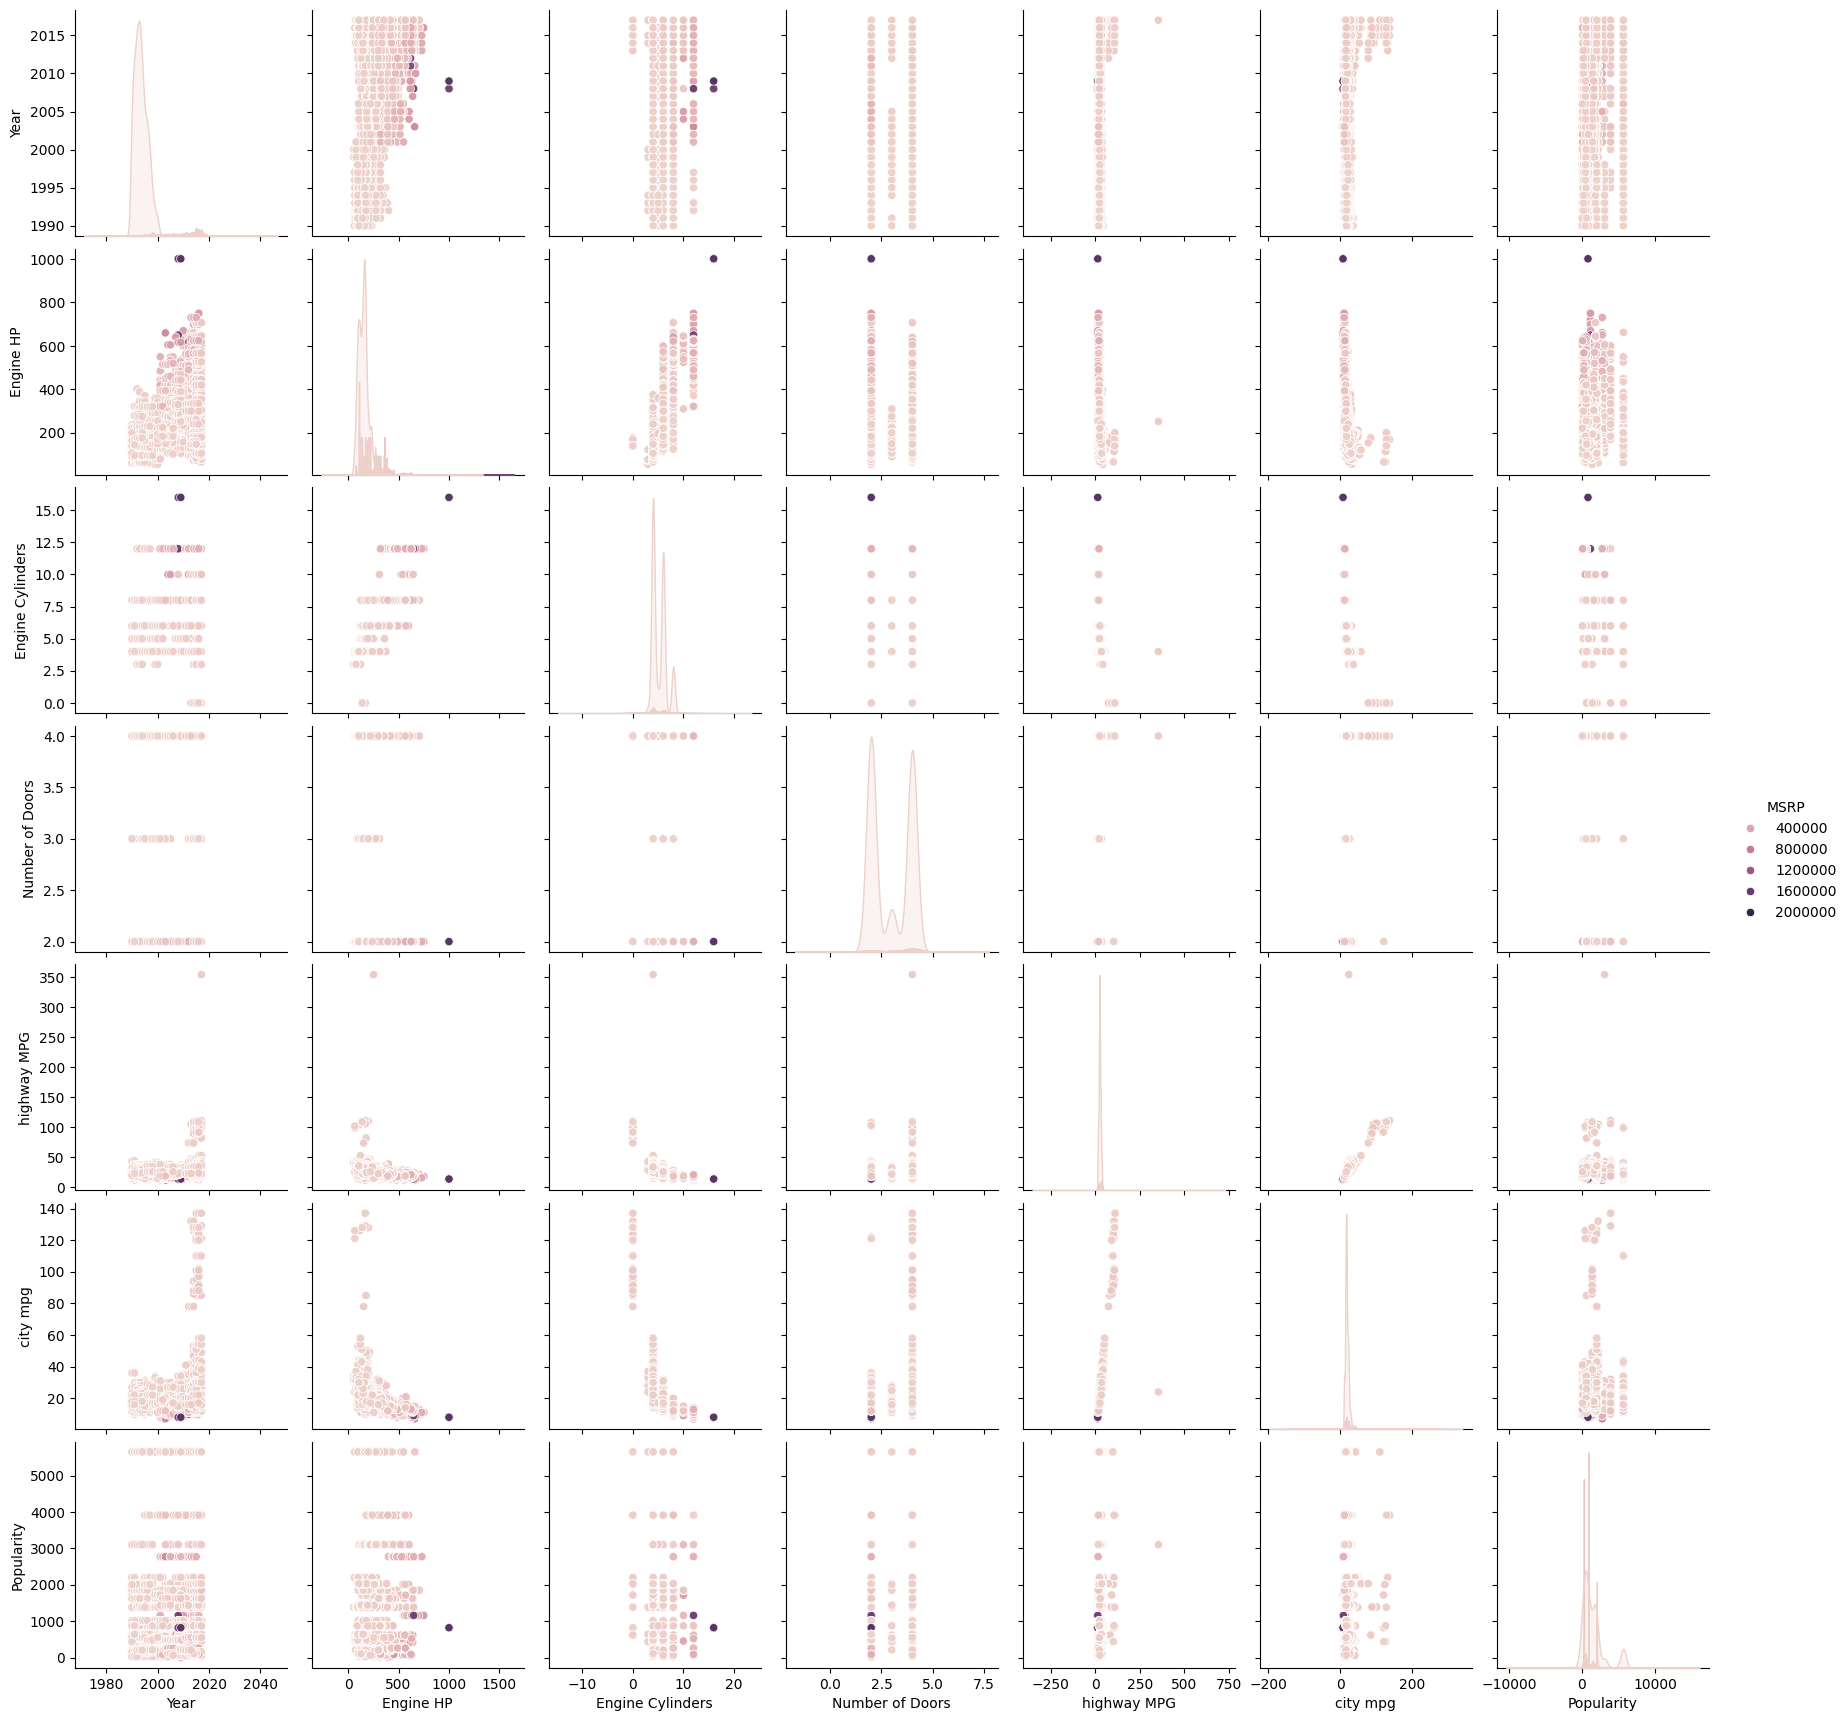

In [ ]:
# Copy Preprocessing from previous assignment (read in data and one plot)
sns.pairplot(df, hue='MSRP')

Based on insights from the last assignment and our new sns plot, we perform the following preprocessing steps on the data:

<ipython-input-62-243c5abb0f89>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MSRP_binned', data=df, palette='viridis')


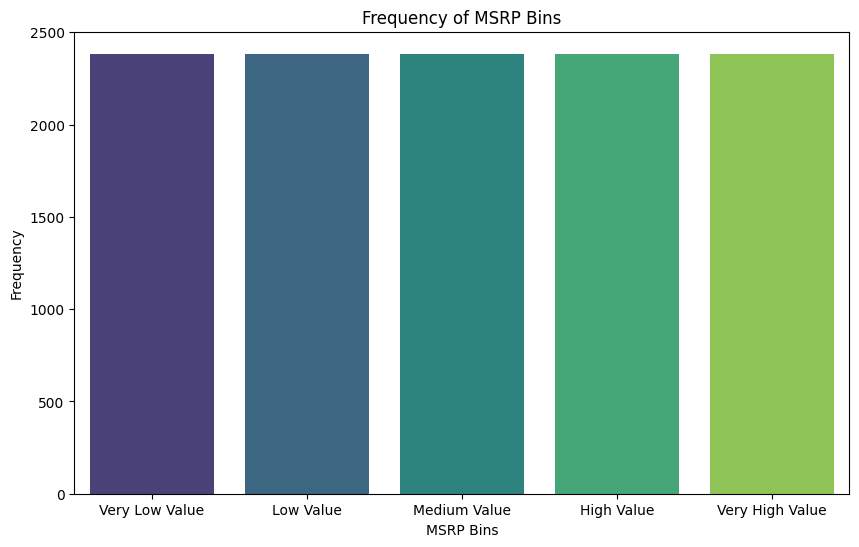

In [62]:
# Handle Missing Values
df.dropna()

# Drop columns/features we don't need anymore
df.drop(columns=['Number of Doors'])

# Normalizing numerical values
scaler = MinMaxScaler()

df[['MSRP', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'Popularity']] = scaler.fit_transform(
    df[['MSRP', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'Popularity']]
)

# Feature Engineering (Binning to create a target variable)
labels = ['Very Low Value', 'Low Value', 'Medium Value', 'High Value', 'Very High Value']
df['MSRP_binned'] = pd.qcut(df['MSRP'], q=5, labels=labels)
plt.figure(figsize=(10, 6))
sns.countplot(x='MSRP_binned', data=df, palette='viridis')
plt.title('Frequency of MSRP Bins')
plt.xlabel('MSRP Bins')
plt.ylabel('Frequency')
plt.show()

In [46]:
# Drop target values
X = df.drop(columns=['MSRP_binned', 'MSRP','Number of Doors']).dropna()

# Encoding categorical values
X = pd.get_dummies(X, columns=['Make', 'Model','Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size','Vehicle Style'])

y = df['MSRP_binned']

### 2. Feature Selection and Dimensionality Reduction [1]

#### a. Select relevant features for model training and justify your selection process.

We use almost all of the features in the dataset, except for the 'Number of Doors' feature, because of the following reasons:
* Removing Number of Doors was based on intuition, seeing as most cars have 4 doors there wouldn't be too much correlation between that and MSRP (can also be seen on the SNSPlot above).
* While we considered removing Model because it had too much cradinality and introduced the danger of overfitting (essentially our Models will become car model classifiers that identify a model and return the price, as opposed to interpretting it's other features so it would work on new car models too). That being said however, it was left in because in the previous assignment, it proved extrememly important with metrics such as information gain and etc. Additionally, with ensemble models there's less of an issue when it comes to overfitting.
* The other features have a complex relationship with our target, as seen by the SNS plots. It is impossible to discern which ones might prove to be significant when it comes to making the best predictions. Luckily, ensemble models are well equipped with dealing with complex functions, therefore not much more action is needed when it comes to our feature selection.



#### b. Apply dimensionality reduction techniques. Besides PCA, explore methods like t-SNE or LDA, depending on whether the primary goal is to preserve class separability (LDA) or data structure in a non-linear manner (t-SNE). Discuss the results and suitability of each method for the dataset.

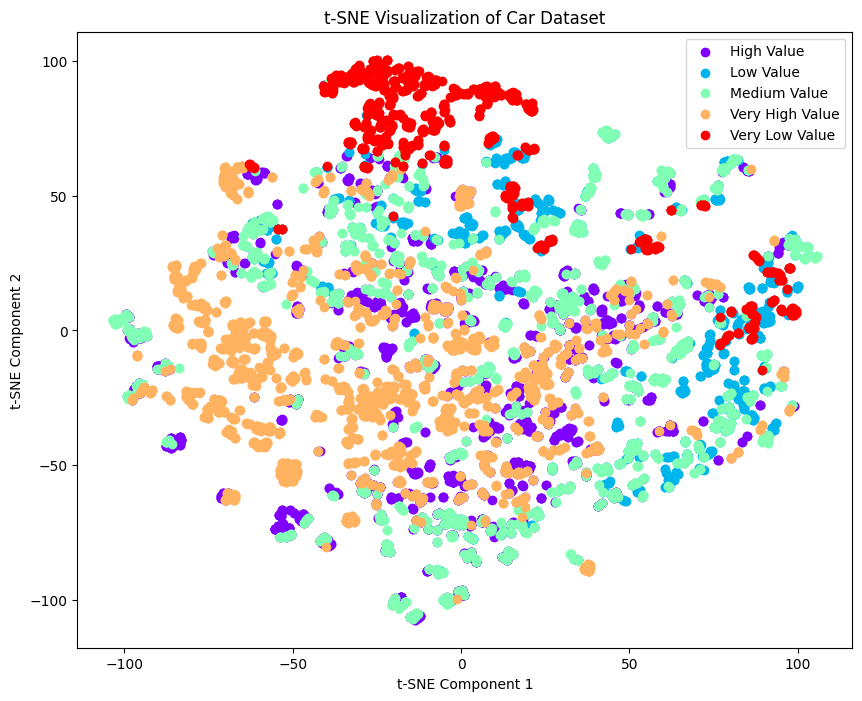

In [41]:
# Implented with the help of the following resource: https://www.geeksforgeeks.org/ml-t-distributed-stochastic-neighbor-embedding-t-sne-algorithm/

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 8))

# 'MSRP_binned' doesn't have too many categories so we just scatter plot it
categories = np.unique(y)
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):

    plt.scatter(X_tsne[y == category, 0], X_tsne[y == category, 1], color=colors[i], label=str(category))

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Car Dataset')
plt.legend()
plt.show()


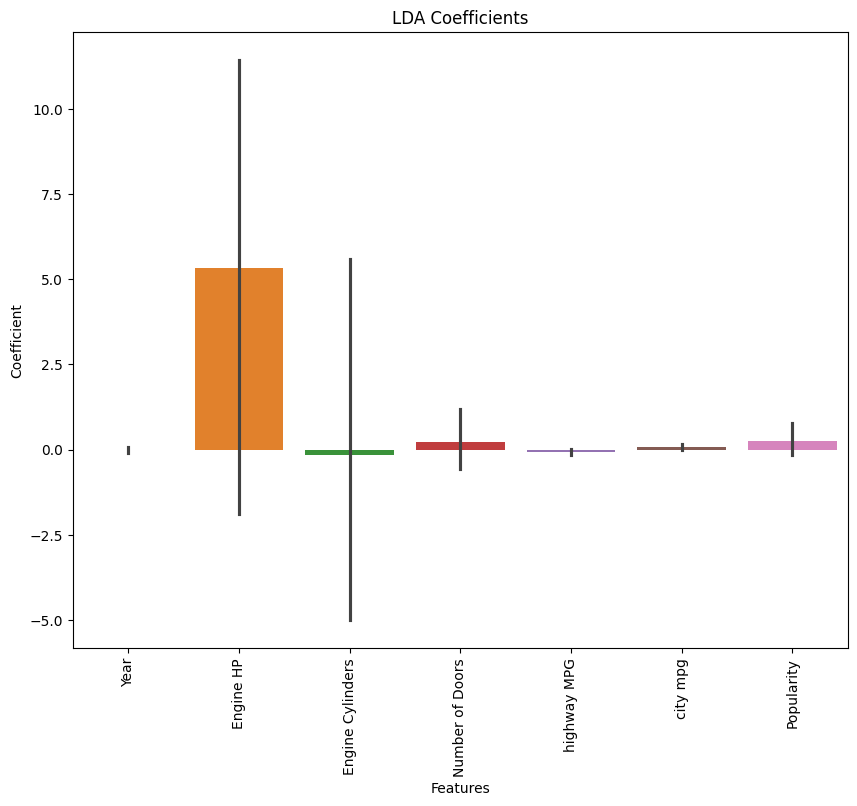

In [47]:
# Define the target variable and the feature matrix
target = 'MSRP_binned'
X_lda = df[['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']]
y_lda = df[target]

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_lda = label_encoder.fit_transform(y_lda)

# Handle missing values in the feature matrix using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_lda)

# Apply Linear Discriminant Analysis (LDA) to reduce dimensionality to 1 component
lda = LDA(n_components=1)
X_lda_m = lda.fit_transform(X_imputed, y_lda)

# Extract the coefficients (scalings) from the LDA model
coefficients = lda.scalings_.T
feature_names = X_lda.columns

# Create a DataFrame with the coefficients and feature names for easier visualization
coeff_df = pd.DataFrame(coefficients, columns=feature_names)

# Plot the LDA coefficients using a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=coeff_df)
plt.xticks(rotation=90)
plt.title('LDA Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

The t-SNE plot seems to sugget that for the most part, extremes such as "Very Low" and "Very High" MSRP, are easy to determine as their clusters do not overlap when compared to the middle three categories that do overlap quite alot.

The LDA plot on the other hand, shows us the continuos features that are most important for actually making the distinction between the classes. So in this case, it tells us the when we want to pick a classify a car, our best bet is to look at its Engine Horsepower.

The t-SNE was the most suitable method for dimensionality reduction for this dataset because it visualized the non-linearity and complexity of our data which gave us a better understanding about how complex our model would need to be to make accurate predictions.

In practice, however, both plots should be used together to make decisions about the model's implementation.

### 3. Model Implementation [1]

#### a. Split the data into training and testing sets (80-20)

In [63]:
y = df.loc[X.index, 'MSRP_binned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### b. Implement a Random Forest model:

In [64]:
# Random forest implementation

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

def random_forest_clf(max_depth):

  rf = RandomForestClassifier(max_depth=max_depth, random_state=42)

  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_test)
  y_pred_proba = rf.predict_proba(X_test)

  return y_pred, y_pred_proba


##### i. Train the model on the training set.

In [65]:
y_pred, y_pred_proba = random_forest_clf(10)

##### ii. Evaluate the model's performance on the testing set using appropriate metrics (e.g., R2 score, RMSE, etc.).

In [66]:
# Evaluation Metrics
f1 = f1_score(y_test, y_pred, average='weighted')
matrix = confusion_matrix(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
accuracy = accuracy_score(y_test, y_pred)

print("F1 score: ", f1)
print("Confusion matrix: ", matrix)
print("ROC and AUC: ", roc_auc)
print("Accuracy: ", accuracy)

F1 score:  0.7640361097093209
Confusion matrix:  [[299   0  34  46   0]
 [  6 166  62   0   4]
 [118  32 178  13   0]
 [ 46   0   0 419   0]
 [  0  17   0   0 177]]
ROC and AUC:  0.9497818118765485
Accuracy:  0.7662337662337663


* F1 score: 0.7640
* AUC: 0.9497
* Accuracy: 0.7662

#### c. Implement an Adaboost model:

##### i. Train the model on the training set.

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
def adaboost_clf(max_depth, n_estimators=50):

  estimator = DecisionTreeClassifier(max_depth=max_depth)

  adaboost_clf = AdaBoostClassifier(estimator=estimator, n_estimators=n_estimators, random_state=42)
  adaboost_clf.fit(X_train, y_train)

  y_pred = adaboost_clf.predict(X_test)
  y_pred_proba = adaboost_clf.predict_proba(X_test)

  return y_pred, y_pred_proba

y_pred, y_pred_proba = adaboost_clf(7)

##### ii. Evaluate the model's performance on the testing set using the same metrics.

In [68]:
# Evaluation Metrics
f1 = f1_score(y_test, y_pred, average='weighted')
matrix = confusion_matrix(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
accuracy = accuracy_score(y_test, y_pred)

print("F1 score: ", f1)
print("Confusion matrix: ", matrix)
print("ROC and AUC: ", roc_auc)
print("Accuracy: ", accuracy)

F1 score:  0.776043712267315
Confusion matrix:  [[278   0  57  44   0]
 [  0 181  48   0   9]
 [ 82  56 200   3   0]
 [ 58   0   0 407   0]
 [  0   4   0   0 190]]
ROC and AUC:  0.9629435432653451
Accuracy:  0.7767470624613482


* F1 score: 0.7760
* AUC: 0.9629
* Accuracy: 0.7767

### 4. Model Comparison and Analysis [1]

#### a. Compare the performance of the Random Forest and Adaboost models.

* F1 Score: Adaboost has a slightly higher F1 score, indicating a better balance between precision and recall.
* Confusion Matrix: Both models have a similar pattern, but Adaboost shows improvements in certain classes, especially in reducing the number of false positives and false negatives.
* ROC and AUC: Adaboost has a higher AUC, indicating it is better at distinguishing between the classes.
* Accuracy: Adaboost has a slightly higher accuracy, suggesting it correctly predicts a higher proportion of instances.

#### b. Discuss which model performed better and why, visualizing the feature importances for both models.

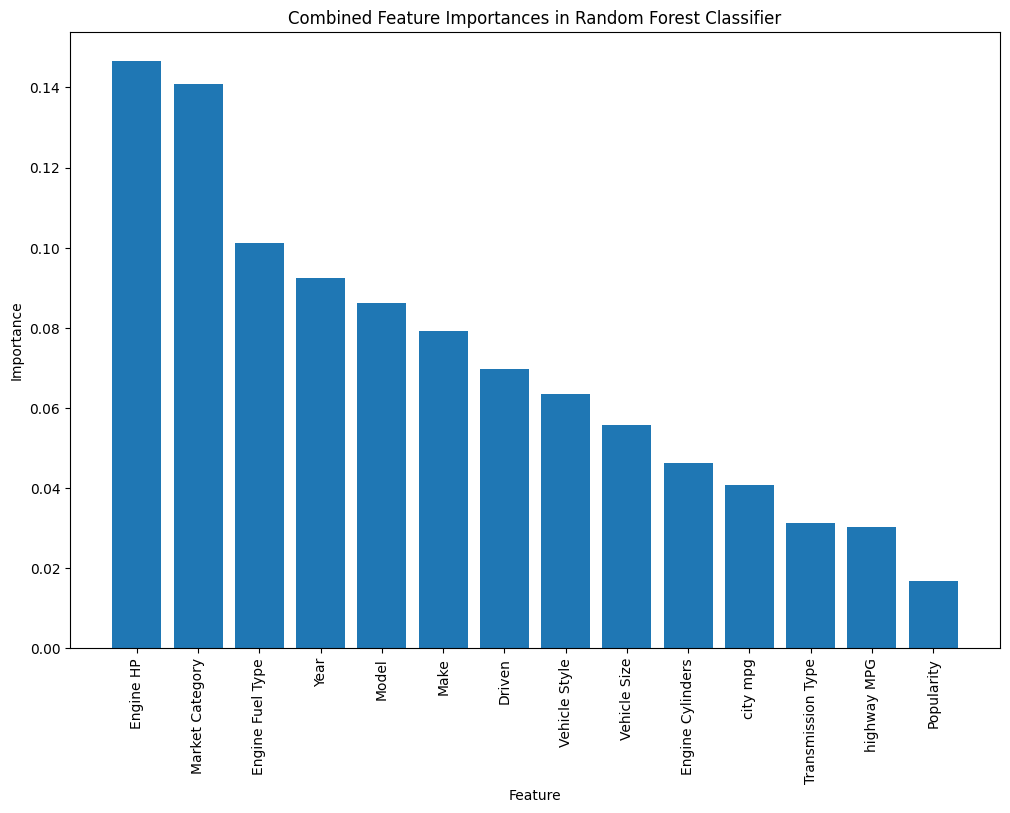

In [69]:
rf = RandomForestClassifier(max_depth=10, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

combined_importances = {}

for feature_name, importance in zip(feature_names, importances):

    original_feature = feature_name.split('_')[0]

    if original_feature in combined_importances:

        combined_importances[original_feature] += importance

    else:

        combined_importances[original_feature] = importance

# Convert to arrays for plotting
combined_feature_names = list(combined_importances.keys())
combined_importance_values = list(combined_importances.values())

# Plot the combined feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(combined_importance_values)[::-1]
plt.bar(range(len(combined_importance_values)), np.array(combined_importance_values)[indices], align='center')
plt.xticks(range(len(combined_importance_values)), np.array(combined_feature_names)[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Combined Feature Importances in Random Forest Classifier')
plt.show()

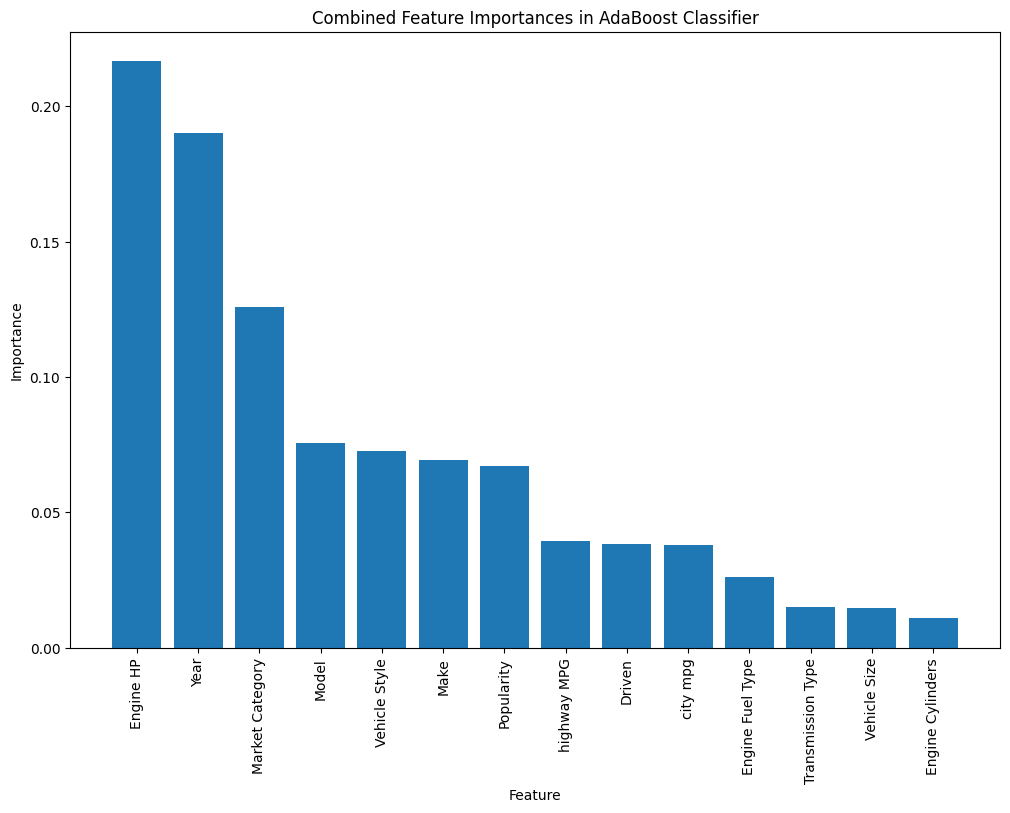

In [70]:
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9), n_estimators= 100, random_state=42)
adaboost.fit(X_train, y_train)

importances = adaboost.feature_importances_
feature_names = X.columns

combined_importances = {}

for feature_name, importance in zip(feature_names, importances):

    original_feature = feature_name.split('_')[0]

    if original_feature in combined_importances:

        combined_importances[original_feature] += importance

    else:

        combined_importances[original_feature] = importance

# Convert to arrays for plotting
combined_feature_names = list(combined_importances.keys())
combined_importance_values = list(combined_importances.values())

# Plot the combined feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(combined_importance_values)[::-1]
plt.bar(range(len(combined_importance_values)), np.array(combined_importance_values)[indices], align='center')
plt.xticks(range(len(combined_importance_values)), np.array(combined_feature_names)[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Combined Feature Importances in AdaBoost Classifier')
plt.show()

Adaboost is slightly better overall, with higher F1 score, AUC, and accuracy, indicating more balanced performance and better class distinction capabilities. But they are relatively similar.

Impact on Model Predictions:
* Top Features:
  * Both models identify Engine HP and Market Category as crucial, but the AdaBoost model emphasizes Engine HP more significantly.
  * Year is very important in the AdaBoost model but less so in the Random Forest model.
* Moderately Important Features:
  * Model and Make are consistently important in both models.
  * Features like Driven, Vehicle Style, and Engine Fuel Type are moderately important across both models, suggesting they contribute but are not as critical as the top features.
* Less Important Features:
  * Number of Doors, Engine Cylinders, and Popularity are less important in both models, suggesting these features do not significantly influence the predictions.

### 5. Hyperparameter Tuning [1]

#### a. Perform hyperparameter tuning for both Random Forest and Adaboost models using techniques such as Grid Search or Random Search.

Grid search implementation made using:

In [71]:
param_grid = {
    'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

# Create the AdaBoostClassifier with a base estimator
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")

Best Parameters: {'max_depth': 15}
Accuracy: 0.808286951144094


In [72]:
param_grid = {
    'estimator__max_depth': [6, 7, 8, 9, 10],
    'n_estimators': [10, 50, 100]
}

# Create the AdaBoostClassifier with a base estimator
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")

Best Parameters: {'estimator__max_depth': 10, 'n_estimators': 100}
Accuracy: 0.8070500927643784


#### b. Employ cross-validation to ensure robustness and avoid overfitting during the tuning process.

Cross-val implementation made using:

In [74]:
rf = RandomForestClassifier(max_depth=15, random_state=42)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
scores = cross_val_score(rf, X, y, cv=5)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.63265306 0.62523191 0.62028448 0.64502165 0.64378479]
Mean cross-validation score: 0.6333951762523191


In [75]:
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9), n_estimators= 100, random_state=42)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
scores = cross_val_score(adaboost, X, y, cv=5)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.6672851  0.64811379 0.64564007 0.65120594 0.65306122]
Mean cross-validation score: 0.653061224489796


#### c. Report the best parameters and the corresponding model performanceimprovements.

Random Forest
* Best Parameters:

	* Max Depth: 15
	* Performance:
		* Post-Tuning Mean Cross-Validation Score: 0.6333
	* Accuracy Increase: 4.21%
	* Final Accuracy: 0.8083


Adaboost
* Best Parameters:

	* Max Depth: 10
	* Number of Estimators: 100
	* Performance:
		* Post-Tuning Mean Cross-Validation Score: 0.6330
	* Accuracy Increase: 3.03%
	* Final Accuracy: 0.8070

### 6. Model Interpretation [0.5]

#### a. Visualize the feature importances using bar plots and discuss their impact on model predictions.

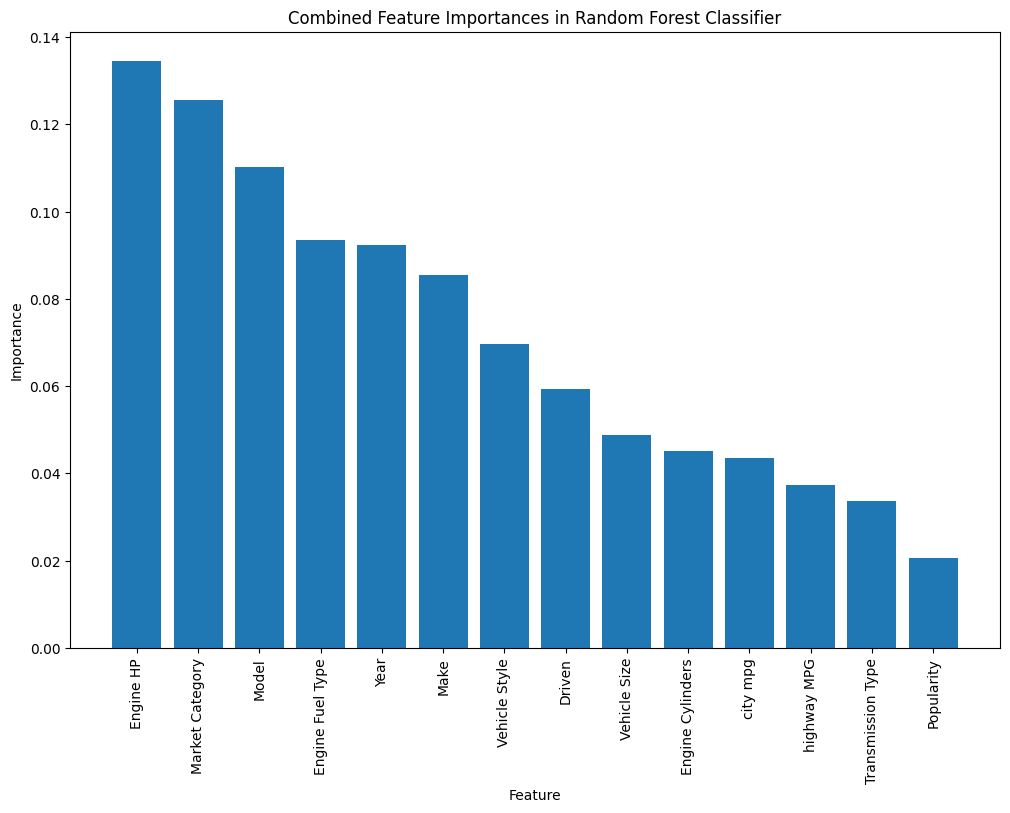

In [76]:
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

combined_importances = {}

for feature_name, importance in zip(feature_names, importances):

    original_feature = feature_name.split('_')[0]

    if original_feature in combined_importances:

        combined_importances[original_feature] += importance

    else:

        combined_importances[original_feature] = importance

# Convert to arrays for plotting
combined_feature_names = list(combined_importances.keys())
combined_importance_values = list(combined_importances.values())

# Plot the combined feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(combined_importance_values)[::-1]
plt.bar(range(len(combined_importance_values)), np.array(combined_importance_values)[indices], align='center')
plt.xticks(range(len(combined_importance_values)), np.array(combined_feature_names)[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Combined Feature Importances in Random Forest Classifier')
plt.show()

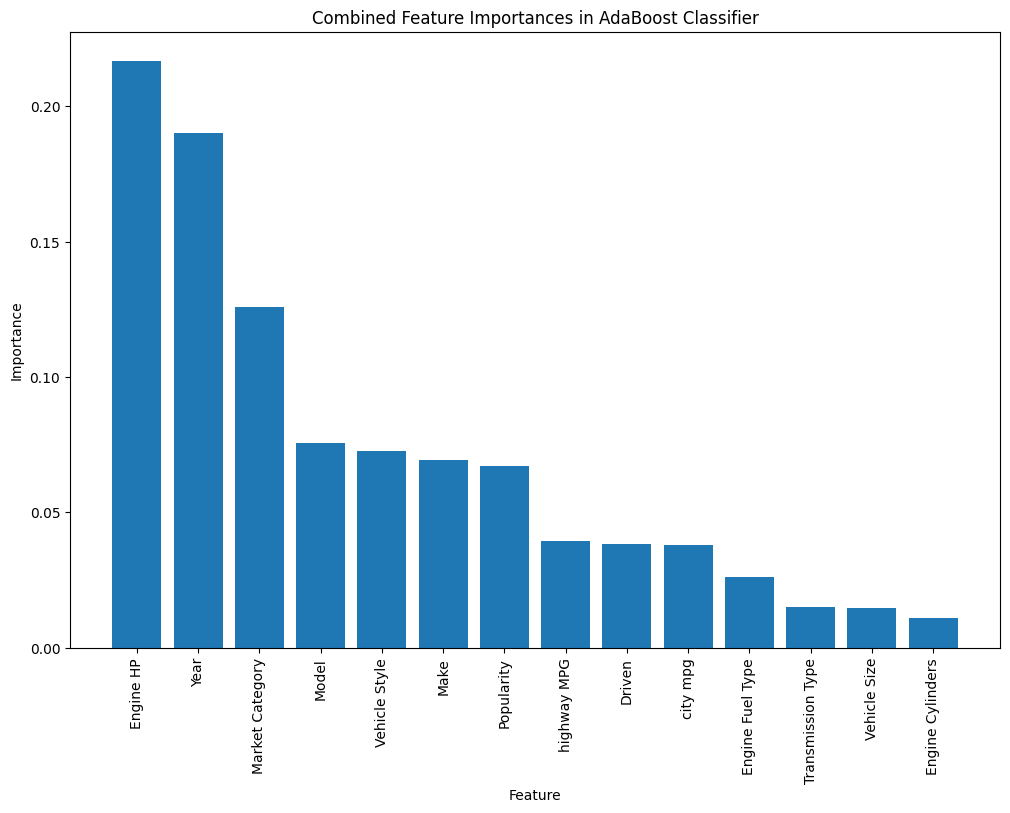

In [77]:
adaboost.fit(X_train, y_train)

importances = adaboost.feature_importances_
feature_names = X.columns

combined_importances = {}

for feature_name, importance in zip(feature_names, importances):

    original_feature = feature_name.split('_')[0]

    if original_feature in combined_importances:

        combined_importances[original_feature] += importance

    else:

        combined_importances[original_feature] = importance

# Convert to arrays for plotting
combined_feature_names = list(combined_importances.keys())
combined_importance_values = list(combined_importances.values())

# Plot the combined feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(combined_importance_values)[::-1]
plt.bar(range(len(combined_importance_values)), np.array(combined_importance_values)[indices], align='center')
plt.xticks(range(len(combined_importance_values)), np.array(combined_feature_names)[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Combined Feature Importances in AdaBoost Classifier')
plt.show()

Impact on Model Predictions:
We did not absorb any significant difference when comparing the graph befor and after hyperparameter tuning but the accuracy went up. This makes sense because tuning did not affect which feature to use that much.

#### b. Conduct an error analysis to identify where model predictions diverge significantly from actual values and discuss possible reasons based on the feature importances and other relevant factors.

Classification Report:

                 precision    recall  f1-score   support

     High Value       0.70      0.81      0.75       379
      Low Value       0.79      0.75      0.77       238
   Medium Value       0.69      0.62      0.65       341
Very High Value       0.93      0.92      0.92       465
 Very Low Value       0.96      0.97      0.97       194

       accuracy                           0.81      1617
      macro avg       0.82      0.81      0.81      1617
   weighted avg       0.81      0.81      0.81      1617



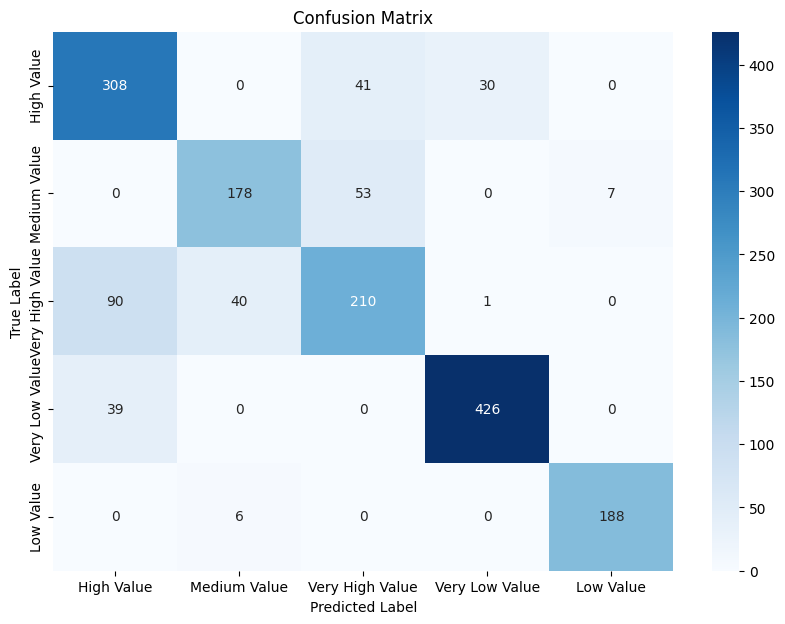

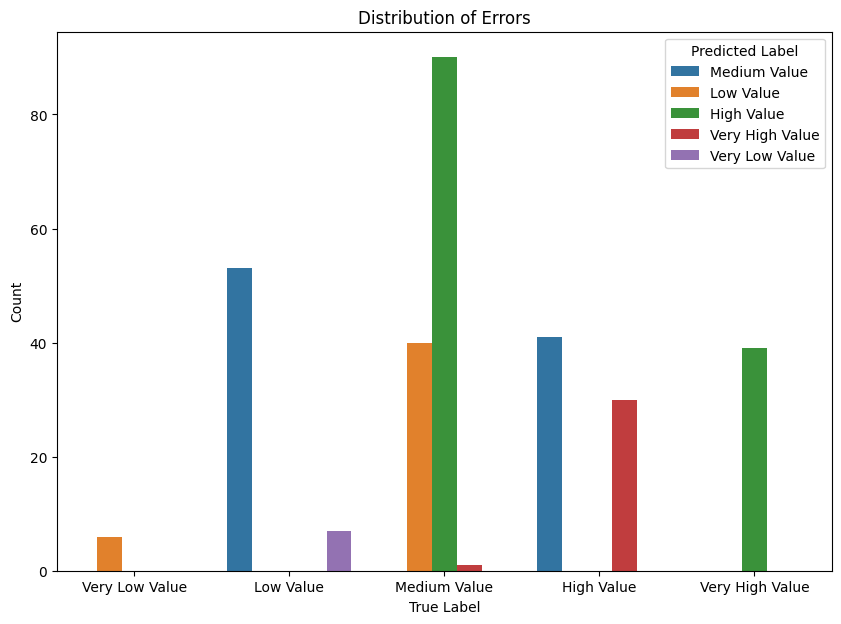

In [78]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and analyze the errors
errors = y_test != y_pred

# Create a DataFrame to analyze the errors
error_analysis_df = X_test.copy()
error_analysis_df['True Label'] = y_test
error_analysis_df['Predicted Label'] = y_pred
error_analysis_df['Error'] = errors

# Optional: Plot the distribution of errors
plt.figure(figsize=(10, 7))
sns.countplot(data=error_analysis_df[error_analysis_df['Error']], x='True Label', hue='Predicted Label')
plt.title('Distribution of Errors')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.legend(title='Predicted Label')
plt.show()

Classification Report:

                 precision    recall  f1-score   support

     High Value       0.73      0.76      0.74       379
      Low Value       0.74      0.80      0.77       238
   Medium Value       0.67      0.57      0.62       341
Very High Value       0.92      0.95      0.94       465
 Very Low Value       0.96      0.97      0.97       194

       accuracy                           0.81      1617
      macro avg       0.80      0.81      0.81      1617
   weighted avg       0.80      0.81      0.80      1617



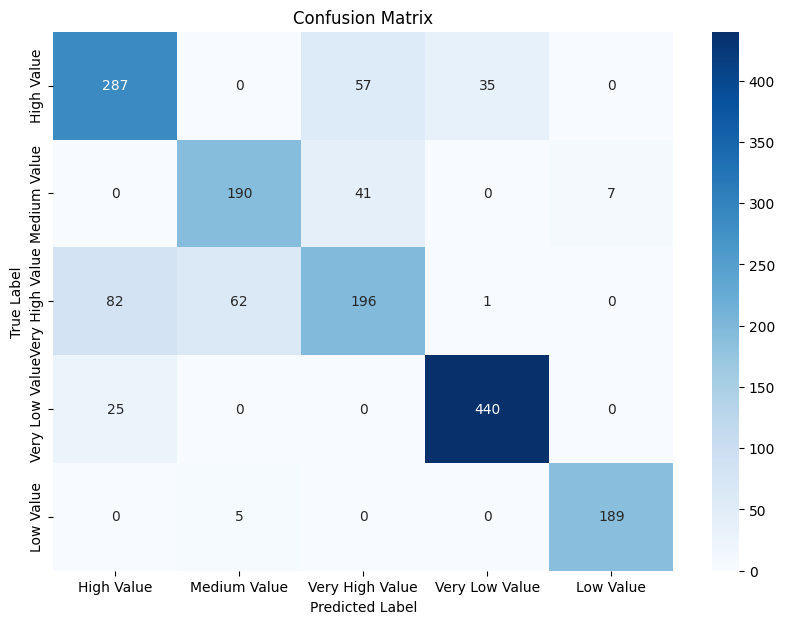

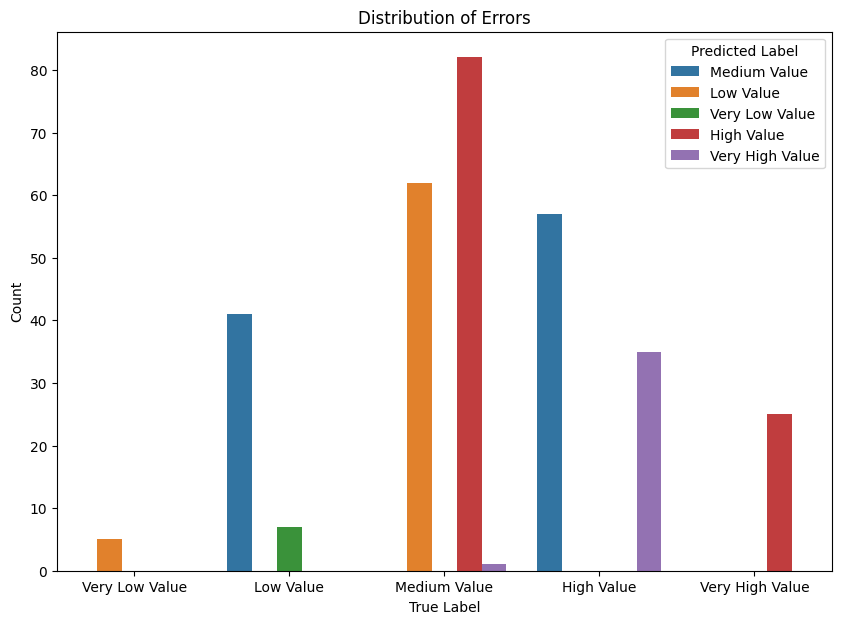

In [79]:
# Make predictions on the test set
y_pred = adaboost.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and analyze the errors
errors = y_test != y_pred

# Create a DataFrame to analyze the errors
error_analysis_df = X_test.copy()
error_analysis_df['True Label'] = y_test
error_analysis_df['Predicted Label'] = y_pred
error_analysis_df['Error'] = errors

# Optional: Plot the distribution of errors
plt.figure(figsize=(10, 7))
sns.countplot(data=error_analysis_df[error_analysis_df['Error']], x='True Label', hue='Predicted Label')
plt.title('Distribution of Errors')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.legend(title='Predicted Label')
plt.show()

The error analysis indicates the following:
* In both models moderate rates of error is more prevalent in classes that contain very specific models and makes, this is due to the importance of this feature being lower in the other classes. For example, if separate models were being used for each class, a model that predicts “Very High MSRP” might look for makes like Ferrari to correctly classify a car, while a model for predicted cars in a more competitive MSRP range might not assign much importance to the make because most Manufacturers put out similar prices to their competitors.
* Adaboost had a harder time with the middle three classes than the Random Forest model. This likely due to Adaboost’s tendency to overfit, which it likely relied heavily to score a higher accuracy.
* Although the Random Forest model fared better with those classes, it also had the highest error when it came to them, this likely due to the overlap in the data we saw earlier in the t-SNE plot. Due to the similarity of the classes the models have no choice but to overfit on features like Market Category, Model, and etc. leading to poor generalization and increased error when it comes to the test set.
* Lower errors on the extreme end might revolve around outliers and/or less important features. No feature has 0 importance in our model, that means all features can influence our prediction, so even if there’s an extreme outlier in a less important feature, that might be the difference between a right or wrong prediction. For example, ‘Engine Cylinders’ doesn’t have a lot of importance in both our models, but generally speaking, more cylinders means a more expensive engine and therefore a more expensive car, but an inefficient or cheaply manufactured engine with a lot of cylinders and a low car MSRP might get categorized as being more expensive because of this one feature.